#Import Libraries

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
import numpy as np
import plotly.graph_objects as go

# Import Data and Initial Cleaning

In [ ]:
# URL to the CSV file
url = "https://drive.google.com/file/d/1fcMAFGRxymGeJBikUL5CM3ZLuBUC5Vlh/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id=" + url.split("/")[-2]

# Read the CSV file
songs_df = pd.read_csv(path)

# Create a copy
spotify_df = songs_df.copy()

# Strip any extra whitespace from the column names
spotify_df.columns = spotify_df.columns.str.strip()


In [ ]:
# Dropping duplicates
spotify_df = spotify_df.drop_duplicates()

Before we work further on the data, it makes sense to drop some of the audio [features](https://developer.spotify.com/documentation/web-api/reference/get-audio-features).
- type
- id
- html

-> those are all non-numerical columns and therefore need to be dropped for any K-means clustering to work.

The other ones don't give us important additional information, or would just distort the data (especially the duration).

In [ ]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5235 entries, 0 to 5234
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5235 non-null   int64  
 1   name              5235 non-null   object 
 2   artist            5235 non-null   object 
 3   danceability      5235 non-null   float64
 4   energy            5235 non-null   float64
 5   key               5235 non-null   int64  
 6   loudness          5235 non-null   float64
 7   mode              5235 non-null   int64  
 8   speechiness       5235 non-null   float64
 9   acousticness      5235 non-null   float64
 10  instrumentalness  5235 non-null   float64
 11  liveness          5235 non-null   float64
 12  valence           5235 non-null   float64
 13  tempo             5235 non-null   float64
 14  type              5235 non-null   object 
 15  duration_ms       5235 non-null   int64  
 16  time_signature    5235 non-null   int64  


In [ ]:
# Getting rid of the non-numerical columns as well as the numerical that don't give me a lot of insights
to_drop = [ "Unnamed: 0","key", "mode", "type","duration_ms","time_signature","id", "html", "liveness"]
spotify_df = spotify_df.drop(columns=to_drop)

In [ ]:
spotify_df

,name,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.6580,0.25900,-13.141,0.0705,0.694,0.000059,0.3060,110.376
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.7420,0.39900,-12.646,0.0346,0.217,0.000002,0.6930,125.039
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.8510,0.73000,-11.048,0.3470,0.453,0.000063,0.9050,93.698
3,Mulher Eu Sei ...,Chico César,0.7050,0.05020,-18.115,0.0471,0.879,0.000041,0.5240,106.802
4,Rosa Morena ...,Kurt Elling,0.6510,0.11900,-19.807,0.0380,0.916,0.000343,0.4020,120.941
...,...,...,...,...,...,...,...,...,...,...
5230,"1812 Festival Overture, Op. 49: 1812 Overture,...",Pyotr Ilyich Tchaikovsky,0.2020,0.06940,-23.390,0.0473,0.917,0.715000,0.0655,87.906
5231,"Winter Fragments pour ensemble instrumental, s...",Tristan Murail,0.1880,0.10100,-21.873,0.0442,0.855,0.426000,0.0355,83.134
5232,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...",Arnold Schoenberg,0.0596,0.00093,-42.959,0.0434,0.951,0.969000,0.0344,71.573
5233,"Serenade For Strings In E, Op.22, B. 52: 1. Mo...",Antonín Dvořák,0.1330,0.02080,-29.443,0.0419,0.883,0.505000,0.0591,67.109


## Drop Outliers

Songs with outlier values in some features shoud be dropped.
- for once the later used StandardScaler is easily affected by outliers
- these outlier songs that exhibit certain specific traits can further be grouped into playlists

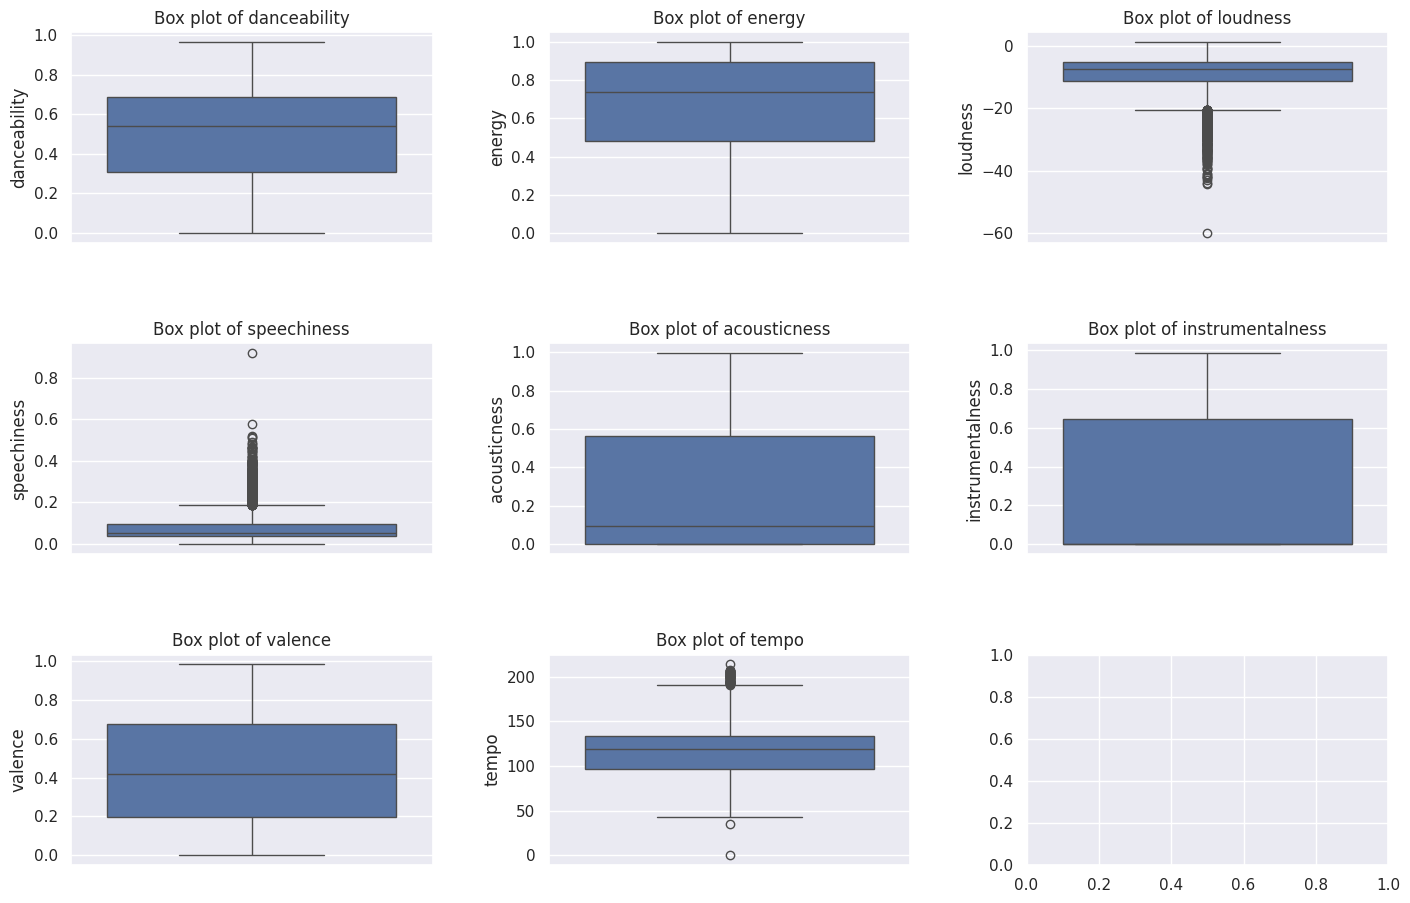

In [ ]:
# Check the different features for outliers

columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']

# Create a figure with a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.tight_layout(pad=4.0)

axes = axes.flatten()


# Plot each box plot
for ax, column in zip(axes, columns):
    sns.boxplot(data=spotify_df, y=column, ax=ax)
    ax.set_title(f'Box plot of {column}')
    ax.set_xlabel('')




In [ ]:
#
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']

# Number of outliers for each feature
outliers_count = {column: count_outliers(spotify_df[column]) for column in columns}
outliers_count

{'danceability': 0,
 'energy': 0,
 'loudness': 355,
 'speechiness': 437,
 'acousticness': 0,
 'instrumentalness': 0,
 'valence': 0,
 'tempo': 51}

In [ ]:
def identify_outliers_df(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Assuming 'spotify_df' is your original dataframe
loudness_outliers = identify_outliers_df(spotify_df, 'loudness')
speechiness_outliers = identify_outliers_df(spotify_df, 'speechiness')

In [ ]:
loudness_outliers

,name,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
25,Rosa Morena - Live At Carnegie Hall/1964 ...,Stan Getz,0.5290,0.13400,-26.821,0.0869,0.906,0.121,0.4740,133.614
40,O Pato (The Duck) - Live At Carnegie Hall/1964...,João Gilberto,0.6210,0.18000,-23.524,0.0619,0.875,0.827,0.8840,169.916
49,Samba Triste ...,Stan Getz,0.6370,0.19000,-22.466,0.0676,0.841,0.263,0.6870,143.111
58,Samba Da Minha Terra - Live At Carnegie Hall/1...,Stan Getz,0.5760,0.32200,-23.134,0.1780,0.879,0.593,0.8050,83.696
114,Violão Vadio ...,Raphael Rabello,0.3640,0.08840,-21.309,0.0410,0.927,0.645,0.1520,89.235
...,...,...,...,...,...,...,...,...,...,...
5230,"1812 Festival Overture, Op. 49: 1812 Overture,...",Pyotr Ilyich Tchaikovsky,0.2020,0.06940,-23.390,0.0473,0.917,0.715,0.0655,87.906
5231,"Winter Fragments pour ensemble instrumental, s...",Tristan Murail,0.1880,0.10100,-21.873,0.0442,0.855,0.426,0.0355,83.134
5232,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...",Arnold Schoenberg,0.0596,0.00093,-42.959,0.0434,0.951,0.969,0.0344,71.573
5233,"Serenade For Strings In E, Op.22, B. 52: 1. Mo...",Antonín Dvořák,0.1330,0.02080,-29.443,0.0419,0.883,0.505,0.0591,67.109


In [ ]:
# Exclude the outliers from the songs

all_outliers = pd.concat([loudness_outliers, speechiness_outliers])
unique_outliers = all_outliers.loc[all_outliers.index.drop_duplicates()]
filtered_spotify_df = spotify_df.drop(index=unique_outliers.index)
filtered_spotify_df

,name,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.658,0.2590,-13.141,0.0705,0.694,0.000059,0.3060,110.376
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.742,0.3990,-12.646,0.0346,0.217,0.000002,0.6930,125.039
3,Mulher Eu Sei ...,Chico César,0.705,0.0502,-18.115,0.0471,0.879,0.000041,0.5240,106.802
4,Rosa Morena ...,Kurt Elling,0.651,0.1190,-19.807,0.0380,0.916,0.000343,0.4020,120.941
5,Desafinado ...,Stan Getz,0.466,0.1460,-17.500,0.0649,0.931,0.154000,0.4230,142.885
...,...,...,...,...,...,...,...,...,...,...
5214,Sinfonia: III. In ruhig fliessender Bewegung ...,Luciano Berio,0.270,0.2560,-18.895,0.0680,0.860,0.151000,0.1740,83.154
5219,"Elgar: Enigma Variations, Op. 36: XV. EDU (Fin...",Edward Elgar,0.146,0.2530,-18.408,0.0398,0.884,0.896000,0.1360,80.359
5223,"Also sprach Zarathustra, Op.30, TrV 176: Prelu...",Richard Strauss,0.115,0.3010,-13.321,0.0449,0.637,0.935000,0.0409,77.276
5225,"Symphony No. 3 - ""Chant de la nuit"", Op. 27: L...",Karol Szymanowski,0.105,0.2310,-18.706,0.0516,0.673,0.053300,0.0348,91.192


# Set Index

The song & artist name are also non-numerical and therefore are not included in the clustering process.
Setting them combined as the index helps us to later identify and compare the songs by checking if an adequate grouping through clustering happened or not.

In [ ]:
# Concatenate "name" and "artist" for unique identifier
filtered_spotify_df ['song & artist'] = filtered_spotify_df ['name'] + " - " + filtered_spotify_df ['artist']

# Drop non-numerical columns before K-means
filtered_spotify_df = filtered_spotify_df .drop(columns=['name', 'artist'])


In [ ]:
# Set song & artist as an index - only numerical columns can be used for the later clustering
filtered_spotify_df  = filtered_spotify_df.set_index('song & artist')

In [ ]:
filtered_spotify_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
song & artist,,,,,,,,
Se Eu Quiser Falar Com Deus - Gilberto Gil,0.658,0.2590,-13.141,0.0705,0.694,0.000059,0.3060,110.376
Saudade De Bahia - Antônio Carlos Jobim,0.742,0.3990,-12.646,0.0346,0.217,0.000002,0.6930,125.039
Mulher Eu Sei - Chico César,0.705,0.0502,-18.115,0.0471,0.879,0.000041,0.5240,106.802
Rosa Morena - Kurt Elling,0.651,0.1190,-19.807,0.0380,0.916,0.000343,0.4020,120.941
Desafinado - Stan Getz,0.466,0.1460,-17.500,0.0649,0.931,0.154000,0.4230,142.885
...,...,...,...,...,...,...,...,...
Sinfonia: III. In ruhig fliessender Bewegung - Luciano Berio,0.270,0.2560,-18.895,0.0680,0.860,0.151000,0.1740,83.154
"Elgar: Enigma Variations, Op. 36: XV. EDU (Finale) - Edward Elgar",0.146,0.2530,-18.408,0.0398,0.884,0.896000,0.1360,80.359
"Also sprach Zarathustra, Op.30, TrV 176: Prelude (Sonnenaufgang) - Richard Strauss",0.115,0.3010,-13.321,0.0449,0.637,0.935000,0.0409,77.276


## Scale the Data

- Different features have different ranges
- With Standardizing (removing the mean and scaling to unit variance) we can ensure that all the features contribute equally

In [ ]:
# Standardize the features
scaler = StandardScaler().set_output(transform="pandas")
filtered_spotify_df_scaled = scaler.fit_transform(filtered_spotify_df)
filtered_spotify_df_scaled

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
song & artist,,,,,,,,
Se Eu Quiser Falar Com Deus - Gilberto Gil,0.653681,-1.692399,-1.181835,0.078790,1.348984,-0.648931,-0.579411,-0.353871
Saudade De Bahia - Antônio Carlos Jobim,1.052600,-1.140087,-1.062298,-0.858130,-0.108066,-0.649092,0.840839,0.192112
Mulher Eu Sei - Chico César,0.876886,-2.516133,-2.382998,-0.531904,1.914088,-0.648983,0.220626,-0.486950
Rosa Morena - Kurt Elling,0.620438,-2.244711,-2.791596,-0.769397,2.027108,-0.648126,-0.227101,0.039521
Desafinado - Stan Getz,-0.258132,-2.138194,-2.234482,-0.067359,2.072927,-0.212750,-0.150033,0.856616
...,...,...,...,...,...,...,...,...
Sinfonia: III. In ruhig fliessender Bewegung - Luciano Berio,-1.188941,-1.704234,-2.571358,0.013545,1.856050,-0.221250,-1.063837,-1.367494
"Elgar: Enigma Variations, Op. 36: XV. EDU (Finale) - Edward Elgar",-1.777821,-1.716070,-2.453754,-0.722420,1.929361,1.889655,-1.203293,-1.471567
"Also sprach Zarathustra, Op.30, TrV 176: Prelude (Sonnenaufgang) - Richard Strauss",-1.925040,-1.526705,-1.225302,-0.589320,1.174871,2.000158,-1.552301,-1.586364


## Principal Component Analysis

Using PCA is going to help to reduce the number of features while preserving the most important ones.
PCA is going to combine features that are highly correlated and otherwise wouldn't add any unique information.

In [ ]:
# Initialise the PCA object
pca_spotify = PCA()

# Fit the PCA object to the data
pca_spotify.fit(filtered_spotify_df_scaled)

# Transform scaled_features_df based on the fit calculations
pca_spotify_df = pd.DataFrame(pca_spotify.transform(filtered_spotify_df_scaled),index=filtered_spotify_df_scaled.index)


In [ ]:
# Get the variance explained by each principal component
explained_variance_spotify = pca_spotify.explained_variance_ratio_
explained_variance_spotify

array([0.33625984, 0.28238922, 0.12368133, 0.08902153, 0.07389273,
       0.04299603, 0.03775513, 0.01400418])

In [ ]:
pd.DataFrame(explained_variance_spotify, columns=["Variance explained"])

,Variance explained
0,0.336260
1,0.282389
2,0.123681
3,0.089022
4,0.073893
5,0.042996
6,0.037755
7,0.014004


In [ ]:
# Calculate cumulative sum of variance
cumulative_sum_of_variance = np.cumsum(explained_variance_spotify)
cumulative_sum_of_variance

array([0.33625984, 0.61864906, 0.74233039, 0.83135192, 0.90524466,
       0.94824069, 0.98599582, 1.        ])

In [ ]:
print("Explained variance by each principal component:")
for i, variance in enumerate(explained_variance_spotify):
    print(f"PC{i + 1}: {variance:.4f}")

print("\nCumulative explained variance:")
for i, cumulative_variance in enumerate(cumulative_sum_of_variance):
    print(f"PC{i + 1}: {cumulative_variance:.4f}")


Explained variance by each principal component:
PC1: 0.3363
PC2: 0.2824
PC3: 0.1237
PC4: 0.0890
PC5: 0.0739
PC6: 0.0430
PC7: 0.0378
PC8: 0.0140

Cumulative explained variance:
PC1: 0.3363
PC2: 0.6186
PC3: 0.7423
PC4: 0.8314
PC5: 0.9052
PC6: 0.9482
PC7: 0.9860
PC8: 1.0000


In [ ]:
# Create a PCA object
pca_spotify = PCA(n_components = 0.95)

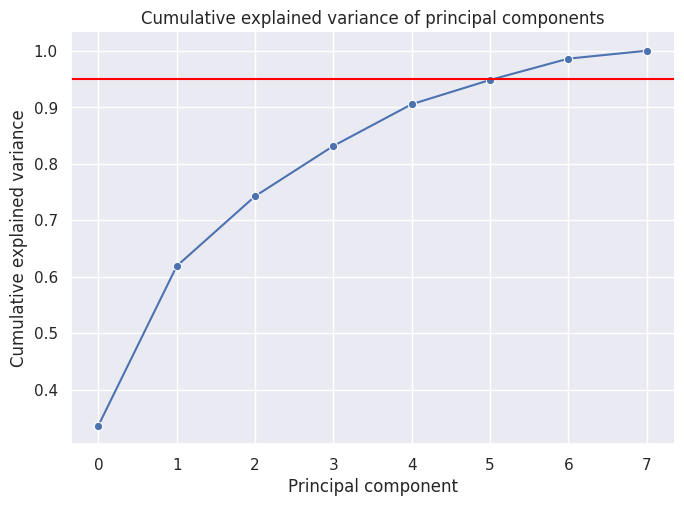

In [ ]:
(
  # Create a cumulative explained variance plot
  sns.relplot(
      kind = "line",  # Create a line plot
      x = range(len(explained_variance_spotify)),
      y = cumulative_sum_of_variance,
      marker = "o",
      aspect = 1.4,
  )

  .set(title="Cumulative explained variance of principal components")

  .set_axis_labels("Principal component", "Cumulative explained variance")
);

# Add a horizontal red line at 0.95 on the y axis
plt.axhline(y = 0.95,
            color = 'red');

I decided to use a threshold of 0.95, meaning that the total numbers of PCAs I'm using should explain more than 95% of the total variance.

It might not be obvious with the visualization, but with the cumulative explained variance above it we can see that 94.82% of the total variance are explained by the first 6 PCAs (PCA 1 is the Principal component 0 in the graph) and therefore we are going to use 7 PCAs to get over threshold of 0.95.

In [ ]:
# Fit the PCA object to the scaled features dataframe and transform it
pca_spotify_df = pca_spotify.fit_transform(filtered_spotify_df_scaled)

# The dataframe now contains the principal components of the scaled features dataframe
pca_spotify_df = pd.DataFrame(pca_spotify_df, index=filtered_spotify_df_scaled.index)
pca_spotify_df

,0,1,2,3,4,5,6
song & artist,,,,,,,
Se Eu Quiser Falar Com Deus - Gilberto Gil,2.214945,-0.730580,-0.352967,0.862805,-0.846266,0.519464,0.314083
Saudade De Bahia - Antônio Carlos Jobim,1.049319,-1.665427,0.413180,0.007040,0.320020,0.105459,1.118312
Mulher Eu Sei - Chico César,3.667780,-1.536773,-0.186099,0.980367,-0.232801,0.118605,0.739337
Rosa Morena - Kurt Elling,3.868375,-1.117501,0.380253,0.828266,-0.460070,0.088322,0.911825
Desafinado - Stan Getz,3.366596,-0.256771,1.070777,1.347341,-0.474659,-0.236952,0.293936
...,...,...,...,...,...,...,...
Sinfonia: III. In ruhig fliessender Bewegung - Luciano Berio,3.682280,0.823681,-1.059435,0.562819,-0.856266,-0.808052,0.504271
"Elgar: Enigma Variations, Op. 36: XV. EDU (Finale) - Edward Elgar",4.244933,2.054886,-0.843103,-0.348254,0.528126,-0.401888,-0.201060
"Also sprach Zarathustra, Op.30, TrV 176: Prelude (Sonnenaufgang) - Richard Strauss",3.145659,2.400035,-1.080670,-0.805748,0.256129,-0.029208,-0.509219


## Ellbow Method for number of Clusters

In [ ]:

# Decide on a random_state to use
seed = 123

# Set the maximum number of clusters to try
max_k = 40

# Create an empty list to store the inertia scores
inertia_list = []
# Create an empty list to store the number of clusters
num_clusters_list = []

# Iterate over the range of cluster numbers
for i in range(1, max_k + 1):

    # Create a KMeans object with the specified number of clusters
    myKMeans = KMeans(n_clusters = i,
                      n_init = "auto",
                      random_state = seed)

    # Fit the KMeans model to the scaled data
    myKMeans.fit(pca_spotify_df)

    # Append the inertia score to the list
    inertia_list.append(myKMeans.inertia_)
    num_clusters_list.append(i)


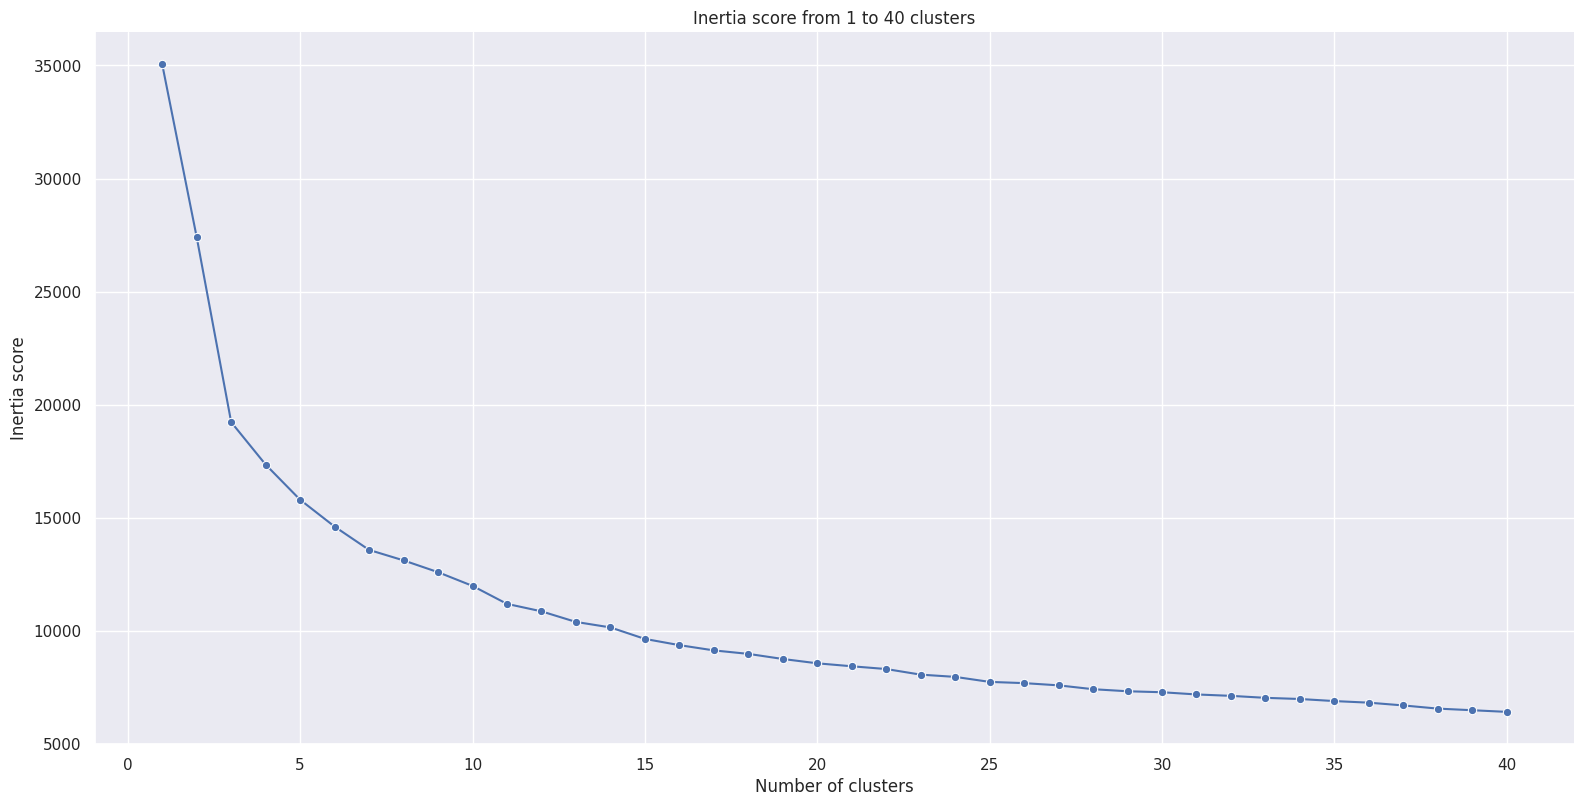

In [ ]:
# Set the Seaborn theme to darkgrid
sns.set_theme(style='darkgrid')

# Create a line plot of the inertia scores
plot = sns.relplot(
    y=inertia_list,
    x=range(1, max_k + 1),
    kind='line',
    marker='o',
    height=8,
    aspect=2
)

# Set the title of the plot
plot.set(title=f"Inertia score from 1 to {max_k} clusters")

# Set the axis labels
plot.set_axis_labels("Number of clusters", "Inertia score")

# Show the plot
plt.show()

In [ ]:
inertia_df = pd.DataFrame({'Number of clusters': num_clusters_list, 'Inertia': inertia_list})
inertia_df


,Number of clusters,Inertia
0,1,35046.235471
1,2,27406.759727
2,3,19229.862136
3,4,17352.381700
4,5,15799.237595
5,6,14612.623793
6,7,13581.417100
7,8,13118.182294
8,9,12597.217122
9,10,11991.023813


In [ ]:
# initialize the model
random_seed = 123

my_full_kmeans = KMeans(n_clusters=24, random_state=random_seed)

# Fit the KMeans model
my_full_kmeans.fit(pca_spotify_df)

# Obtain the cluster labels
group = my_full_kmeans.labels_

# Add the cluster labels as a new column in pca_spotify_df
pca_spotify_df['group'] = group

pca_spotify_df.sort_values(by="group")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,0,1,2,3,4,5,6,group
song & artist,,,,,,,,
Propane Nightmares - Pendulum,-1.763256,1.189191,1.719859,-0.058813,-0.978638,0.114217,-0.147937,0
"I'll Be There for You - Theme From ""Friends"" - The Rembrandts",-1.632563,0.086976,2.537770,0.441465,-0.257021,-1.120006,-0.087622,0
Orgasmatron - Sepultura,-1.672467,0.441251,0.352925,0.109798,-0.763335,-0.014214,0.177704,0
Pain Divine - Morbid Angel,-0.748730,1.002452,0.731990,-0.501908,-0.593129,-0.168036,0.831757,0
Follow Jesus - Master,-1.002080,1.402580,1.707978,0.217102,-0.688775,-0.465940,0.561551,0
...,...,...,...,...,...,...,...,...
The Ibex Moon - Incantation,-0.773713,3.427593,0.243842,0.190441,0.303784,0.208202,-0.144714,23
The Cemetary's Full - Deceased…,-0.622587,3.075238,-1.668026,0.416200,0.642221,-0.120505,-0.032711,23
Morbid Shape in Black - Deceased…,-1.093701,2.932547,-1.236668,0.598102,1.023068,-0.216099,-0.443365,23


In [ ]:
pca_spotify_df

,0,1,2,3,4,5,6,group
song & artist,,,,,,,,
Se Eu Quiser Falar Com Deus - Gilberto Gil,2.214945,-0.730580,-0.352967,0.862805,-0.846266,0.519464,0.314083,21
Saudade De Bahia - Antônio Carlos Jobim,1.049319,-1.665427,0.413180,0.007040,0.320020,0.105459,1.118312,12
Mulher Eu Sei - Chico César,3.667780,-1.536773,-0.186099,0.980367,-0.232801,0.118605,0.739337,21
Rosa Morena - Kurt Elling,3.868375,-1.117501,0.380253,0.828266,-0.460070,0.088322,0.911825,21
Desafinado - Stan Getz,3.366596,-0.256771,1.070777,1.347341,-0.474659,-0.236952,0.293936,6
...,...,...,...,...,...,...,...,...
Sinfonia: III. In ruhig fliessender Bewegung - Luciano Berio,3.682280,0.823681,-1.059435,0.562819,-0.856266,-0.808052,0.504271,2
"Elgar: Enigma Variations, Op. 36: XV. EDU (Finale) - Edward Elgar",4.244933,2.054886,-0.843103,-0.348254,0.528126,-0.401888,-0.201060,7
"Also sprach Zarathustra, Op.30, TrV 176: Prelude (Sonnenaufgang) - Richard Strauss",3.145659,2.400035,-1.080670,-0.805748,0.256129,-0.029208,-0.509219,7


In [ ]:
spotify_merged_df = filtered_spotify_df_scaled.merge(pca_spotify_df[['group']], left_index=True, right_index=True, how='left')


In [ ]:
spotify_merged_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,group
song & artist,,,,,,,,,
"'54, '74, '90, 2006 - Sportfreunde Stiller",0.140786,0.935029,0.657824,0.261476,-0.645373,-0.649098,0.789460,0.451010,9
"'54, '74, '90, 2010 - Sportfreunde Stiller",0.117041,1.045492,0.636090,0.767778,-0.626129,-0.649098,0.260995,0.453468,16
'A bertoela - Bruno Lauzi,0.539705,-0.402355,-0.335418,1.135761,1.367312,-0.649098,1.339945,-0.990858,8
'Long As You Know You're Living Yours - Keith Jarrett,0.401983,-1.230824,-1.625449,-0.920765,0.001900,-0.062578,1.776663,0.448590,12
'O sole mio (Arr. Chiaramello) - Eduardo di Capua,-1.212686,-1.649003,-1.388066,-0.792885,2.124856,-0.292086,-0.682168,-1.734077,2
...,...,...,...,...,...,...,...,...,...
Água de beber - Tania Maria,1.190322,-0.524653,-0.994681,-0.474489,1.889651,0.546609,0.327053,-0.811197,21
Águas De Março - Antônio Carlos Jobim,0.563450,-0.536488,-0.250655,1.553330,1.770521,-0.649098,0.037132,0.869872,17
É Normal - B Fachada,1.166576,-0.761358,-1.664328,-0.312681,-0.043920,1.487308,1.523440,0.152978,12


In [ ]:
spotify_merged_df = spotify_merged_df = spotify_merged_df.drop_duplicates()

In [ ]:
spotify_merged_df.groupby('group').size()

,0
group,
0,170
1,330
2,120
3,111
4,217
5,180
6,71
7,134
8,159


In [ ]:
spotify_merged_df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,group
count,4395.000000,4395.000000,4395.000000,4395.000000,4395.000000,4395.000000,4395.000000,4395.000000,4395.000000
mean,-0.009458,-0.000509,-0.006182,0.001071,0.002489,0.009651,-0.003735,-0.000244,11.345392
std,0.999345,1.003178,1.001019,1.001058,1.002561,1.004922,1.001448,1.003591,6.768957
min,-2.178639,-2.662496,-2.945665,-1.171307,-0.770917,-0.649098,-1.621295,-2.498148,0.000000
25%,-0.922996,-0.619335,-0.539476,-0.774616,-0.766885,-0.649094,-0.878508,-0.781855,5.000000
50%,0.136037,0.272255,0.246086,-0.357048,-0.553429,-0.645528,-0.098655,0.004818,12.000000
75%,0.796152,0.842320,0.731840,0.512018,0.573112,0.726532,0.851849,0.521255,18.000000
max,2.121131,1.230911,2.315641,3.145311,2.268423,2.121996,1.912449,3.504242,23.000000


## Using Radar Charts to visualize the Clusters

In [ ]:
import builtins  # Import built-in functions to avoid naming conflicts

# Define the column names for the radar chart (excluding 'group')
categories = spotify_merged_df.columns[:-1]

# Get the min and max values for each category
min_values = spotify_merged_df[categories].min()
max_values = spotify_merged_df[categories].max()

# Compute the overall min and max for the radar chart
overall_min = builtins.min(min_values.min(), -3)
overall_max = builtins.max(max_values.max(), 4)

# Create an empty list to store the Scatterpolar objects for each group
scatter_objects = []

# Iterate over the unique groups and create a Scatterpolar object for each
for group in sorted(spotify_merged_df['group'].unique()):
    # Calculate mean values for each category within the group
    group_means = [spotify_merged_df.loc[spotify_merged_df["group"] == group, category].mean() for category in categories]

    # Create a Scatterpolar object for the group
    group_scatter = go.Scatterpolar(
        r=group_means,
        theta=categories,
        fill='toself',
        name=f'Group {group}'
    )

    # Add the Scatterpolar object to the list
    scatter_objects.append(group_scatter)

# Create the figure
fig = go.Figure()

# Add the scatter objects to the figure
fig.add_traces(scatter_objects)

# Update the layout with extras like title
fig.update_layout(
    title_text='Radar Chart of Mean Attributes by Group',
    height=600,
    width=800,
    polar=dict(
        radialaxis=dict(
            visible=True,  # Visibility of the numbers on the arm
            range=[overall_min, overall_max]  # Adjust range based on min and max values
        )
    ),
    showlegend=True
)

# Show the initialized plot
fig.show()


# Creating Playlists for the outliers

The same steps that have been used to create the playlist are now going to be used to create playlist for the songs that have previously been dropped from the dataframe.

In [ ]:
loudness_outliers

,name,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
25,Rosa Morena - Live At Carnegie Hall/1964 ...,Stan Getz,0.5290,0.13400,-26.821,0.0869,0.906,0.121,0.4740,133.614
40,O Pato (The Duck) - Live At Carnegie Hall/1964...,João Gilberto,0.6210,0.18000,-23.524,0.0619,0.875,0.827,0.8840,169.916
49,Samba Triste ...,Stan Getz,0.6370,0.19000,-22.466,0.0676,0.841,0.263,0.6870,143.111
58,Samba Da Minha Terra - Live At Carnegie Hall/1...,Stan Getz,0.5760,0.32200,-23.134,0.1780,0.879,0.593,0.8050,83.696
114,Violão Vadio ...,Raphael Rabello,0.3640,0.08840,-21.309,0.0410,0.927,0.645,0.1520,89.235
...,...,...,...,...,...,...,...,...,...,...
5230,"1812 Festival Overture, Op. 49: 1812 Overture,...",Pyotr Ilyich Tchaikovsky,0.2020,0.06940,-23.390,0.0473,0.917,0.715,0.0655,87.906
5231,"Winter Fragments pour ensemble instrumental, s...",Tristan Murail,0.1880,0.10100,-21.873,0.0442,0.855,0.426,0.0355,83.134
5232,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...",Arnold Schoenberg,0.0596,0.00093,-42.959,0.0434,0.951,0.969,0.0344,71.573
5233,"Serenade For Strings In E, Op.22, B. 52: 1. Mo...",Antonín Dvořák,0.1330,0.02080,-29.443,0.0419,0.883,0.505,0.0591,67.109


In [ ]:
# Concatenate 'name' and 'artist' into a new column 'song & artist'
loudness_outliers['song & artist'] = loudness_outliers['name'] + ' - ' + loudness_outliers['artist']

# Drop the non numerica
loudness_outliers = loudness_outliers.drop(columns=['name', 'artist'])

<ipython-input-122-18c1aedab071>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
loudness_outliers

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,song & artist
25,0.5290,0.13400,-26.821,0.0869,0.906,0.121,0.4740,133.614,Rosa Morena - Live At Carnegie Hall/1964 ...
40,0.6210,0.18000,-23.524,0.0619,0.875,0.827,0.8840,169.916,O Pato (The Duck) - Live At Carnegie Hall/1964...
49,0.6370,0.19000,-22.466,0.0676,0.841,0.263,0.6870,143.111,Samba Triste ...
58,0.5760,0.32200,-23.134,0.1780,0.879,0.593,0.8050,83.696,Samba Da Minha Terra - Live At Carnegie Hall/1...
114,0.3640,0.08840,-21.309,0.0410,0.927,0.645,0.1520,89.235,Violão Vadio ...
...,...,...,...,...,...,...,...,...,...
5230,0.2020,0.06940,-23.390,0.0473,0.917,0.715,0.0655,87.906,"1812 Festival Overture, Op. 49: 1812 Overture,..."
5231,0.1880,0.10100,-21.873,0.0442,0.855,0.426,0.0355,83.134,"Winter Fragments pour ensemble instrumental, s..."
5232,0.0596,0.00093,-42.959,0.0434,0.951,0.969,0.0344,71.573,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3..."
5233,0.1330,0.02080,-29.443,0.0419,0.883,0.505,0.0591,67.109,"Serenade For Strings In E, Op.22, B. 52: 1. Mo..."


In [ ]:
loudness_outliers = loudness_outliers.set_index("song & artist")

In [ ]:
loudness_outliers

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
song & artist,,,,,,,,
Rosa Morena - Live At Carnegie Hall/1964 - Stan Getz,0.5290,0.13400,-26.821,0.0869,0.906,0.121,0.4740,133.614
O Pato (The Duck) - Live At Carnegie Hall/1964 - João Gilberto,0.6210,0.18000,-23.524,0.0619,0.875,0.827,0.8840,169.916
Samba Triste - Stan Getz,0.6370,0.19000,-22.466,0.0676,0.841,0.263,0.6870,143.111
Samba Da Minha Terra - Live At Carnegie Hall/1964 - Stan Getz,0.5760,0.32200,-23.134,0.1780,0.879,0.593,0.8050,83.696
Violão Vadio - Raphael Rabello,0.3640,0.08840,-21.309,0.0410,0.927,0.645,0.1520,89.235
...,...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49 - Pyotr Ilyich Tchaikovsky",0.2020,0.06940,-23.390,0.0473,0.917,0.715,0.0655,87.906
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique - Tristan Murail",0.1880,0.10100,-21.873,0.0442,0.855,0.426,0.0355,83.134
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours) - Arnold Schoenberg",0.0596,0.00093,-42.959,0.0434,0.951,0.969,0.0344,71.573


In [ ]:
speechiness_outliers

,name,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.851,0.730,-11.048,0.347,0.453000,0.000063,0.9050,93.698
7,O Meu Amor É Glòria ...,Sílvia Pérez Cruz,0.504,0.733,-10.720,0.389,0.696000,0.000056,0.8860,96.565
26,Karoliina Kaunis ...,Maria Gasolina,0.753,0.215,-15.671,0.293,0.618000,0.004640,0.3820,130.338
28,Aquarela Do Brasil ...,Gal Costa,0.553,0.550,-13.401,0.398,0.800000,0.000723,0.6790,137.016
122,Vai (Menina amanhã de manhã) ...,Tom Zé,0.671,0.630,-10.367,0.237,0.885000,0.000000,0.7940,127.645
...,...,...,...,...,...,...,...,...,...,...
5109,Follow God ...,Kanye West,0.529,0.900,-3.503,0.418,0.000248,0.000012,0.4340,180.291
5110,Happy - Live/Remastered ...,Tasha Cobbs Leonard,0.401,0.885,-5.753,0.445,0.172000,0.000000,0.4390,172.952
5113,God's Gonna Do It - Live ...,Ricky Dillard,0.500,0.984,-4.984,0.289,0.001810,0.000012,0.2840,159.928
5127,You Brought The Sunshine - Live ...,The Clark Sisters,0.507,0.910,-3.058,0.250,0.120000,0.000000,0.5030,124.592


In [ ]:
# Concatenate 'name' and 'artist' into a new column 'song & artist'
speechiness_outliers['song & artist'] = speechiness_outliers['name'] + ' - ' + speechiness_outliers['artist']

# Drop the non numerica
speechiness_outliers = speechiness_outliers.drop(columns=['name', 'artist'])

<ipython-input-127-fa75b9530cc8>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
speechiness_outliers = speechiness_outliers.set_index("song & artist")

In [ ]:
speechiness_outliers

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
song & artist,,,,,,,,
"Canta Canta, Minha Gente - Martinho Da Vila",0.851,0.730,-11.048,0.347,0.453000,0.000063,0.9050,93.698
O Meu Amor É Glòria - Sílvia Pérez Cruz,0.504,0.733,-10.720,0.389,0.696000,0.000056,0.8860,96.565
Karoliina Kaunis - Maria Gasolina,0.753,0.215,-15.671,0.293,0.618000,0.004640,0.3820,130.338
Aquarela Do Brasil - Gal Costa,0.553,0.550,-13.401,0.398,0.800000,0.000723,0.6790,137.016
Vai (Menina amanhã de manhã) - Tom Zé,0.671,0.630,-10.367,0.237,0.885000,0.000000,0.7940,127.645
...,...,...,...,...,...,...,...,...
Follow God - Kanye West,0.529,0.900,-3.503,0.418,0.000248,0.000012,0.4340,180.291
Happy - Live/Remastered - Tasha Cobbs Leonard,0.401,0.885,-5.753,0.445,0.172000,0.000000,0.4390,172.952
God's Gonna Do It - Live - Ricky Dillard,0.500,0.984,-4.984,0.289,0.001810,0.000012,0.2840,159.928


# Scale the data for the outliers

In [ ]:
# Standardize the features
loudness_outliers_scaled = scaler.fit_transform(loudness_outliers)
speechiness_outliers_scaled = scaler.fit_transform(speechiness_outliers)

# PCA for the outliers

In [ ]:
# 1. Initialize the PCA object
pca_loudness = PCA()

# 2. Fit the PCA object to the loudness scaled data
pca_loudness.fit(loudness_outliers_scaled)

# 3. Transform the loudness scaled data based on the fit calculations
pca_loudness_df = pd.DataFrame(pca_loudness.transform(loudness_outliers_scaled), index=loudness_outliers_scaled.index)
pca_loudness_df

,0,1,2,3,4,5,6,7
song & artist,,,,,,,,
Rosa Morena - Live At Carnegie Hall/1964 - Stan Getz,3.987856,0.614554,2.034436,0.003527,-0.700102,0.947526,-0.420427,0.349134
O Pato (The Duck) - Live At Carnegie Hall/1964 - João Gilberto,5.748282,0.419214,0.261049,-0.146498,2.065757,-0.643465,-1.489518,-1.088801
Samba Triste - Stan Getz,5.306676,-0.290858,1.652768,-0.029432,0.378960,-0.468124,-0.862515,-0.058231
Samba Da Minha Terra - Live At Carnegie Hall/1964 - Stan Getz,7.786760,1.849986,1.439210,5.096255,-1.117148,3.596260,-0.886626,-0.617189
Violão Vadio - Raphael Rabello,0.535475,-0.684321,0.004963,0.076652,-0.589676,-0.811160,0.244465,0.040801
...,...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49 - Pyotr Ilyich Tchaikovsky",-0.500575,-0.661854,0.000467,0.259857,-0.606573,0.147164,0.175541,-0.271071
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique - Tristan Murail",-0.398804,-1.602921,0.786517,0.237233,-1.038822,0.094530,0.160780,0.030261
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours) - Arnold Schoenberg",-2.847979,1.486091,0.725741,0.384267,1.159732,0.848082,-0.822092,0.367853


In [ ]:
# 4. Get the variance explained by each principal component
explained_variance_loudness = pca_loudness.explained_variance_ratio_


In [ ]:
explained_variance_loudness_df = pd.DataFrame(explained_variance_loudness, columns=["Variance explained"])
explained_variance_loudness_df

,Variance explained
0,0.250907
1,0.202508
2,0.142710
3,0.117110
4,0.101739
5,0.085264
6,0.063098
7,0.036664


In [ ]:
# Calculate cumulative sum of variance
cumulative_sum_of_variance_loudness = np.cumsum(explained_variance_loudness)
cumulative_sum_of_variance_loudness

array([0.25090695, 0.45341505, 0.59612466, 0.7132345 , 0.81497336,
       0.9002375 , 0.96333583, 1.        ])

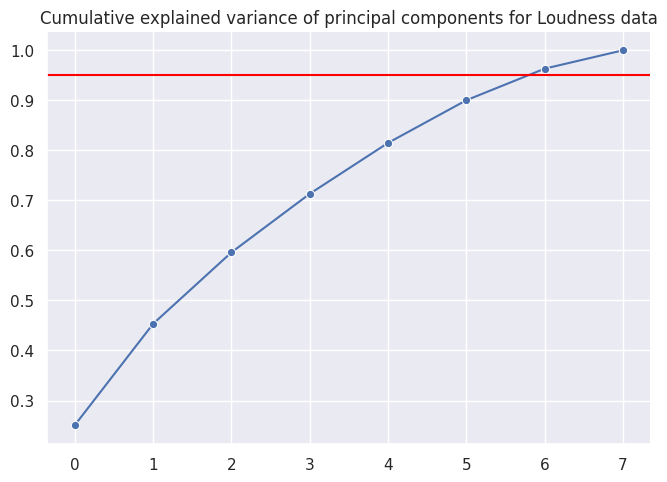

In [ ]:
# 5. Create a cumulative explained variance plot
sns.relplot(
    kind="line",  # Create a line plot
    x=range(len(explained_variance_loudness)),  # Set the x-axis to be the principal component index
    y=cumulative_sum_of_variance_loudness,  # Set the y-axis to be the cumulative explained variance
    marker="o",  # Use a circle marker for the data points
    aspect=1.4  # Set the aspect ratio of the plot to be 1.4
).set(title="Cumulative explained variance of principal components for Loudness data")

# Add a horizontal red line at 0.95 on the y-axis
plt.axhline(y=0.95, color='red')
plt.show()

In [ ]:
# 6. Fit the PCA object to retain 95% of variance and transform the data
pca_loudness_95 = PCA(n_components=0.95)
pca_loudness_df = pd.DataFrame(pca_loudness_95.fit_transform(loudness_outliers_scaled), index=loudness_outliers_scaled.index)
pca_loudness_df

,0,1,2,3,4,5,6
song & artist,,,,,,,
Rosa Morena - Live At Carnegie Hall/1964 - Stan Getz,3.987856,0.614554,2.034436,0.003527,-0.700102,0.947526,-0.420427
O Pato (The Duck) - Live At Carnegie Hall/1964 - João Gilberto,5.748282,0.419214,0.261049,-0.146498,2.065757,-0.643465,-1.489518
Samba Triste - Stan Getz,5.306676,-0.290858,1.652768,-0.029432,0.378960,-0.468124,-0.862515
Samba Da Minha Terra - Live At Carnegie Hall/1964 - Stan Getz,7.786760,1.849986,1.439210,5.096255,-1.117148,3.596260,-0.886626
Violão Vadio - Raphael Rabello,0.535475,-0.684321,0.004963,0.076652,-0.589676,-0.811160,0.244465
...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49 - Pyotr Ilyich Tchaikovsky",-0.500575,-0.661854,0.000467,0.259857,-0.606573,0.147164,0.175541
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique - Tristan Murail",-0.398804,-1.602921,0.786517,0.237233,-1.038822,0.094530,0.160780
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours) - Arnold Schoenberg",-2.847979,1.486091,0.725741,0.384267,1.159732,0.848082,-0.822092


In [ ]:
# 1. Initialize the PCA object
pca_speechiness = PCA()

# 2. Fit the PCA object to the speechiness scaled data
pca_speechiness.fit(speechiness_outliers_scaled)

# 3. Transform the speechiness scaled data based on the fit calculations
pca_speechiness_df = pd.DataFrame(pca_speechiness.transform(speechiness_outliers_scaled), index=speechiness_outliers_scaled.index)

In [ ]:
# 4. Get the variance explained by each principal component
explained_variance_speechiness = pca_speechiness.explained_variance_ratio_

In [ ]:
# Convert explained variance to a DataFrame
explained_variance_speechiness_df = pd.DataFrame(explained_variance_speechiness, columns=["Variance explained"])
explained_variance_speechiness_df

,Variance explained
0,0.379304
1,0.171904
2,0.142318
3,0.107891
4,0.077614
5,0.056601
6,0.042520
7,0.021847


In [ ]:
# Calculate cumulative sum of variance
cumulative_sum_of_variance_speechiness = np.cumsum(explained_variance_speechiness)
cumulative_sum_of_variance_speechiness

array([0.37930368, 0.55120813, 0.69352655, 0.80141777, 0.87903218,
       0.93563306, 0.97815314, 1.        ])

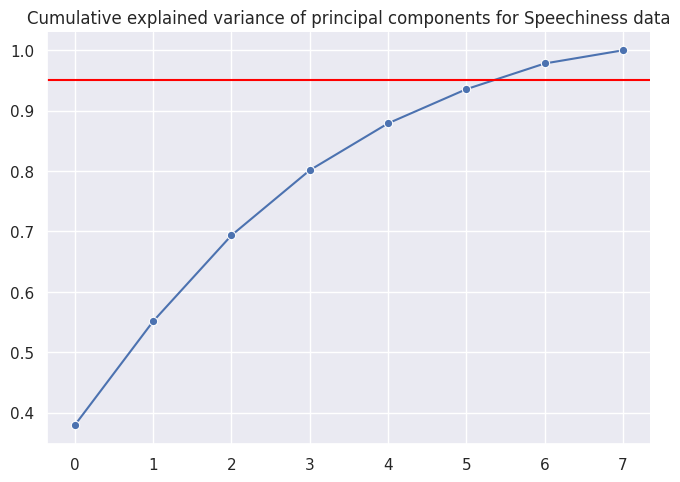

In [ ]:
# 5. Create a cumulative explained variance plot
sns.relplot(
    kind="line",  # Create a line plot
    x=range(len(explained_variance_speechiness)),  # Set the x-axis to be the principal component index
    y=cumulative_sum_of_variance_speechiness,  # Set the y-axis to be the cumulative explained variance
    marker="o",  # Use a circle marker for the data points
    aspect=1.4  # Set the aspect ratio of the plot to be 1.4
).set(title="Cumulative explained variance of principal components for Speechiness data")

# Add a horizontal red line at 0.95 on the y-axis
plt.axhline(y=0.95, color='red')
plt.show()


In [ ]:
# 6. Fit the PCA object to retain 95% of variance and transform the data
pca_speechiness_95 = PCA(n_components=0.95)
pca_speechiness_df = pd.DataFrame(pca_speechiness_95.fit_transform(speechiness_outliers_scaled), index=speechiness_outliers_scaled.index)

# View the transformed PCA DataFrame
pca_speechiness_df

,0,1,2,3,4,5,6
song & artist,,,,,,,
"Canta Canta, Minha Gente - Martinho Da Vila",-2.555052,1.182909,-0.280808,0.569214,0.629866,0.297885,-1.321889
O Meu Amor É Glòria - Sílvia Pérez Cruz,-2.298493,1.712258,0.388243,0.463904,2.095990,-0.120570,-1.614476
Karoliina Kaunis - Maria Gasolina,-3.207738,4.097251,0.458205,-0.645896,-0.262217,-0.978670,0.657986
Aquarela Do Brasil - Gal Costa,-2.845344,2.981998,1.414010,-0.244773,1.681452,-0.461969,-0.891825
Vai (Menina amanhã de manhã) - Tom Zé,-2.759643,1.825757,-0.235852,-1.688894,2.018034,-0.405062,-0.656272
...,...,...,...,...,...,...,...
Follow God - Kanye West,0.457650,-1.379494,2.463499,0.571055,-0.021449,0.215331,0.049030
Happy - Live/Remastered - Tasha Cobbs Leonard,0.195805,-0.360117,2.645724,0.642696,0.623030,-0.096797,-0.429946
God's Gonna Do It - Live - Ricky Dillard,1.166717,-0.970861,1.100992,-0.184909,-0.260814,-0.516027,-0.131580


In [ ]:

# Decide on a random_state to use
seed = 123

# Set the maximum number of clusters to try
max_k = 20

# Create an empty list to store the inertia scores
inertia_list = []
# Create an empty list to store the number of clusters
num_clusters_list = []

# Iterate over the range of cluster numbers
for i in range(1, max_k + 1):

    # Create a KMeans object with the specified number of clusters
    myKMeans = KMeans(n_clusters = i,
                      n_init = "auto",
                      random_state = seed)

    # Fit the KMeans model to the scaled data
    myKMeans.fit(pca_loudness_df)

    # Append the inertia score to the list
    inertia_list.append(myKMeans.inertia_)
    num_clusters_list.append(i)

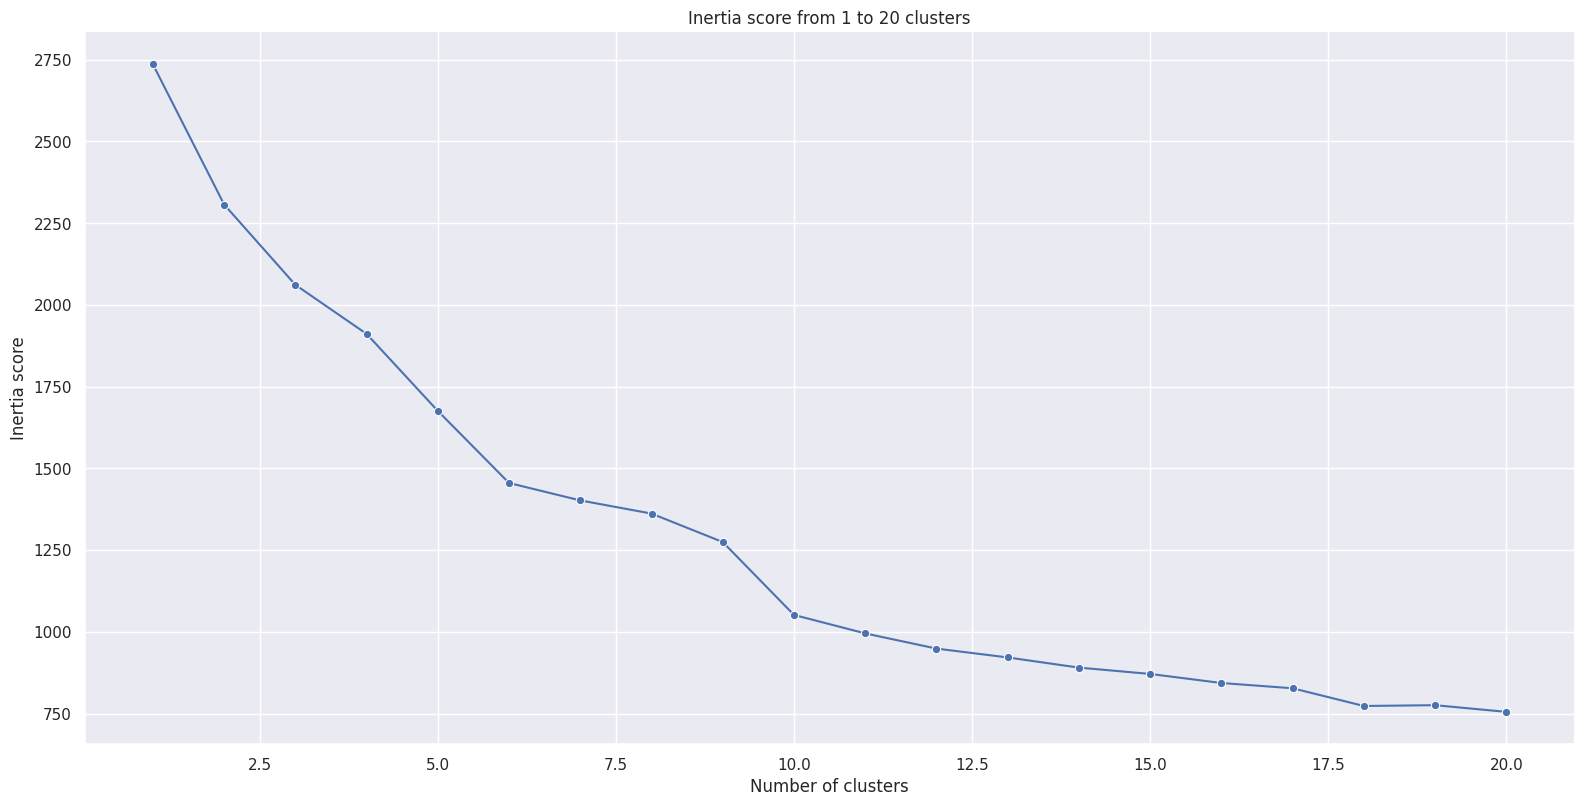

In [ ]:
# Set the Seaborn theme to darkgrid
sns.set_theme(style='darkgrid')

# Create a line plot of the inertia scores
plot = sns.relplot(
    y=inertia_list,
    x=range(1, max_k + 1),
    kind='line',
    marker='o',
    height=8,
    aspect=2
)

# Set the title of the plot
plot.set(title=f"Inertia score from 1 to {max_k} clusters")

# Set the axis labels
plot.set_axis_labels("Number of clusters", "Inertia score")

# Show the plot
plt.show()

In [ ]:

# Decide on a random_state to use
seed = 123

# Set the maximum number of clusters to try
max_k = 20

# Create an empty list to store the inertia scores
inertia_list = []
# Create an empty list to store the number of clusters
num_clusters_list = []

# Iterate over the range of cluster numbers
for i in range(1, max_k + 1):

    # Create a KMeans object with the specified number of clusters
    myKMeans = KMeans(n_clusters = i,
                      n_init = "auto",
                      random_state = seed)

    # Fit the KMeans model to the scaled data
    myKMeans.fit(pca_speechiness_df)

    # Append the inertia score to the list
    inertia_list.append(myKMeans.inertia_)
    num_clusters_list.append(i)

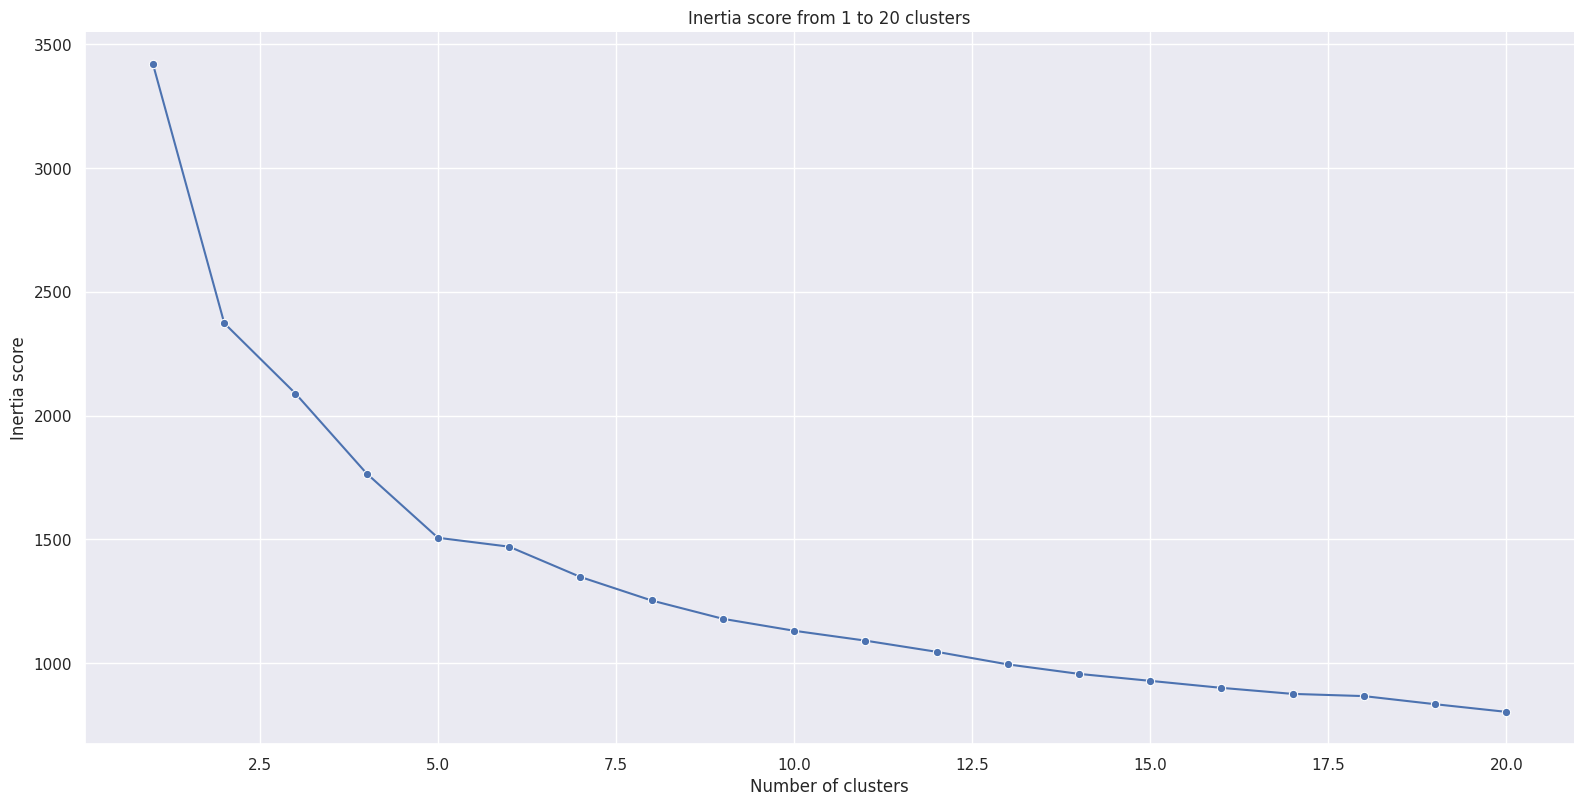

In [ ]:
# Set the Seaborn theme to darkgrid
sns.set_theme(style='darkgrid')

# Create a line plot of the inertia scores
plot = sns.relplot(
    y=inertia_list,
    x=range(1, max_k + 1),
    kind='line',
    marker='o',
    height=8,
    aspect=2
)

# Set the title of the plot
plot.set(title=f"Inertia score from 1 to {max_k} clusters")

# Set the axis labels
plot.set_axis_labels("Number of clusters", "Inertia score")

# Show the plot
plt.show()

In [ ]:
# initialize the model
random_seed = 123

my_full_kmeans = KMeans(n_clusters=4, random_state=random_seed)

# Fit the KMeans model
my_full_kmeans.fit(pca_loudness_df)

# Obtain the cluster labels
group = my_full_kmeans.labels_

# Add the cluster labels as a new column in pca_loudness_df
pca_loudness_df['group'] = group

pca_loudness_df.sort_values(by="group")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,0,1,2,3,4,5,6,group
song & artist,,,,,,,,
Rosa Morena - Live At Carnegie Hall/1964 - Stan Getz,3.987856,0.614554,2.034436,0.003527,-0.700102,0.947526,-0.420427,0
Saltare (Somewhere at the Baltic Sea) - Dirk Maassen,0.851628,0.436018,-0.832077,1.554607,-1.162762,0.218956,0.799740,0
Music for 18 Musicians: Pulses - Steve Reich,3.859128,-1.177043,-1.347235,1.876608,0.794125,-0.414693,-1.522583,0
Challen - Goldbæk,0.741638,0.072685,-0.728938,0.029308,-0.305451,-0.880668,0.691556,0
From Gagarin's Point of View - Esbjörn Svensson Trio,1.142444,-1.225415,1.064805,0.424613,1.782191,-1.382759,3.132809,0
...,...,...,...,...,...,...,...,...
My Funny Valentine - Chet Baker,1.308826,0.071391,1.977983,-2.162908,-0.850329,-0.744196,-0.124037,3
Young And Foolish - Bill Evans,0.378558,0.202813,0.263875,-0.855362,-0.685481,-1.046283,0.608545,3
I Get Along Without You Very Well (Except Sometimes) - Vocal Version - Chet Baker,1.144567,-0.399573,1.896007,-1.295611,-1.468685,-0.997794,0.206937,3


In [ ]:
# initialize the model
random_seed = 123

my_full_kmeans = KMeans(n_clusters=5, random_state=random_seed)

# Fit the KMeans model
my_full_kmeans.fit(pca_speechiness_df)

# Obtain the cluster labels
group = my_full_kmeans.labels_

# Add the cluster labels as a new column in pca_speechiness_df
pca_speechiness_df['group'] = group

pca_speechiness_df.sort_values(by="group")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,0,1,2,3,4,5,6,group
song & artist,,,,,,,,
Dancing Alone - Axwell /\ Ingrosso,-0.046347,-0.926482,-0.629809,-0.507811,-0.319339,-0.056488,-0.739854,0
212 - Azealia Banks,-0.692536,-0.877538,-0.188646,0.074592,-0.827955,0.270463,0.030552,0
Juicy - 2005 Remaster - The Notorious B.I.G.,-1.712802,-0.746295,-1.037882,-0.274260,1.311823,0.270231,-0.131985,0
Bow Wow (That's My Name) (feat. Snoop Dogg) - Bow Wow,-1.929973,-1.276293,-1.106681,0.256638,0.215209,0.816626,0.090664,0
Feet On The Ground - Nicky Romero,0.307756,-1.325090,-0.382175,-0.600450,0.590703,-0.439641,0.641705,0
...,...,...,...,...,...,...,...,...
Live Your Life - T.I.,0.798553,-1.195010,0.848934,-0.701172,0.047644,-0.316325,-0.048890,4
Bad Boy for Life - Diddy,-0.833028,-0.984761,1.548875,1.963640,0.964925,0.531035,-0.065405,4
Candy Shop - 50 Cent,-1.517380,0.359991,1.556483,1.794828,-0.611787,0.576118,-0.416937,4


In [ ]:
spotify_loudness_merged_df = loudness_outliers_scaled.merge(pca_loudness_df[['group']], left_index=True, right_index=True, how='left')
spotify_loudness_merged_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,group
song & artist,,,,,,,,,
#20 - Aphex Twin,-1.026476,-0.360997,0.057012,-0.226175,0.283473,0.503292,-0.705888,1.200614,1
#3 - Aphex Twin,-0.849643,0.061939,-0.063000,-0.362684,-0.255295,0.294069,-0.574740,1.263989,1
1/1 - Remastered 2004 - Brian Eno,-0.191824,-0.915627,-0.780372,-0.387503,0.382247,0.503292,-0.747489,-0.517144,2
"10 Chorale Preludes, BV B 27: No. 2, Wachet auf, ruft uns die Stimme, BWV 645 - Johann Sebastian Bach",-0.290851,-0.746015,-1.649602,-0.362684,0.507959,0.463612,1.122430,1.038213,2
"10 Chorale Preludes, BV B 27: No. 5, Ich ruf zu dir, Herr Jesu Christ, BWV 639 - Johann Sebastian Bach",-0.658663,-0.911397,-2.572811,0.307451,0.507959,0.434754,0.262211,-0.989998,2
...,...,...,...,...,...,...,...,...,...
door to the cosmos - Chihei Hatakeyama,-0.948669,-0.762057,-0.383631,-0.207560,0.498980,0.737767,-0.770757,1.126779,1
drivers license - Piano Version - Octavien X,0.614534,-0.573924,0.471745,-0.201355,0.427144,0.441968,-0.731272,1.146667,1
unother - Terekke,-0.297924,0.283616,-0.638049,-0.288224,0.490000,0.037950,-0.731977,-0.899192,2


In [ ]:
spotify_loudness_merged_df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,group
count,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000
mean,0.004759,-0.007518,-0.006041,0.019361,0.005009,0.006391,-0.001539,0.003916,1.270195
std,1.002157,0.998600,1.001844,1.058332,0.996937,0.997653,0.999095,1.004228,0.934729
min,-2.030886,-0.973525,-5.981181,-2.906713,-8.435579,-2.790175,-1.006965,-2.958516,0.000000
25%,-0.849643,-0.721222,-0.547005,-0.480578,-0.035298,0.129936,-0.727041,-0.812880,1.000000
50%,-0.043285,-0.290994,0.248635,-0.226175,0.373267,0.449183,-0.397055,-0.367148,1.000000
75%,0.734780,0.339764,0.777892,0.158532,0.472041,0.557402,0.332721,0.841282,2.000000
max,2.906288,6.858082,1.134958,8.138096,0.507959,0.763018,5.226098,3.021993,3.000000


In [ ]:
spotify_speechiness_merged_df = speechiness_outliers_scaled.merge(pca_speechiness_df[['group']], left_index=True, right_index=True, how='left')
spotify_speechiness_merged_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,group
song & artist,,,,,,,,,
#SELFIE - The Chainsmokers,0.963696,0.767271,1.119420,-0.497870,-0.657751,-0.457528,0.609969,0.177198,0
11 PM - Maluma,0.832766,-0.388809,0.536763,0.059707,0.356932,-0.457561,0.731737,-0.750787,0
110 - Capital Bra,-0.421631,-0.178095,0.455869,2.023901,1.933332,-0.457561,-0.231343,1.644869,4
21 Questions - 50 Cent,0.279480,0.186383,0.907307,0.338496,1.015428,-0.457219,1.525079,-0.835935,0
212 - Azealia Banks,1.056615,-0.069891,0.266869,-0.105032,-0.667229,-0.456940,0.550929,0.119378,0
...,...,...,...,...,...,...,...,...,...
Youngblood - 5 Seconds of Summer,0.068302,0.419878,0.434621,2.416740,-0.641288,-0.457561,-1.216563,-0.044367,4
Youngblood - 5 Seconds of Summer,0.068302,0.419878,0.434621,2.416740,-0.641288,-0.457561,-1.216563,-0.044367,4
bad guy - Billie Eilish,0.511776,-2.023268,-1.746521,1.301585,0.910668,0.017262,0.296322,0.382497,3


In [ ]:
spotify_speechiness_merged_df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,group
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,-0.000125,-0.016069,-0.001259,0.046758,-0.006937,-0.020022,0.009092,0.020366,1.748359
std,0.986481,1.004120,1.004462,1.023668,1.000085,0.983419,0.996472,1.015258,1.600481
min,-2.005466,-3.219213,-3.812474,-1.055448,-0.725588,-0.457561,-1.661941,-2.270271,0.000000
25%,-0.928458,-0.673558,-0.374687,-0.751315,-0.713474,-0.457561,-0.873396,-0.774782,0.000000
50%,0.262586,0.100959,0.201260,-0.219082,-0.525054,-0.457546,0.163483,-0.198600,1.000000
75%,0.807425,0.898256,0.609455,0.553924,0.317023,-0.407157,0.860886,0.809188,3.000000
max,1.601454,1.239954,2.745491,8.182600,3.689323,3.008645,1.805516,2.418390,4.000000


In [ ]:
import plotly.graph_objects as go

# Define the column names for the radar chart (excluding 'group')
categories = spotify_loudness_merged_df.columns[:-1]

# Get the min and max values for each category
min_values = spotify_loudness_merged_df[categories].min()
max_values = spotify_loudness_merged_df[categories].max()

# Create an empty list to store the Scatterpolar objects for each group
scatter_objects = []

# Iterate over the unique groups and create a Scatterpolar object for each
for group in sorted(spotify_loudness_merged_df['group'].unique()):
    # Calculate mean values for each category within the group
    group_means = [spotify_loudness_merged_df.loc[spotify_loudness_merged_df["group"] == group, category].mean() for category in categories]

    # Create a Scatterpolar object for the group
    group_scatter = go.Scatterpolar(
        r=group_means,
        theta=categories,
        fill='toself',
        name=f'Group {group}'
    )

    # Add the Scatterpolar object to the list
    scatter_objects.append(group_scatter)

# Create the figure
fig = go.Figure()

# Add the scatter objects to the figure
fig.add_traces(scatter_objects)

# Update the layout with extras like title
fig.update_layout(
    title_text='Radar Chart of Mean Attributes by Group (Loudness)',
    height=600,
    width=800,
    polar=dict(
        radialaxis=dict(
            visible=True,  # Visibility of the numbers on the arm
            range=[min(min_values.min(), -8.5), max(max_values.max(), 8.5)]  # Adjust range based on min and max values
        )
    ),
    showlegend=True
)

# Show the initialized plot
fig.show()


In [ ]:
loudness_group_2_df = spotify_loudness_merged_df[spotify_loudness_merged_df['group'] == 2]
loudness_group_2_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,group
song & artist,,,,,,,,,
1/1 - Remastered 2004 - Brian Eno,-0.191824,-0.915627,-0.780372,-0.387503,0.382247,0.503292,-0.747489,-0.517144,2
"10 Chorale Preludes, BV B 27: No. 2, Wachet auf, ruft uns die Stimme, BWV 645 - Johann Sebastian Bach",-0.290851,-0.746015,-1.649602,-0.362684,0.507959,0.463612,1.122430,1.038213,2
"10 Chorale Preludes, BV B 27: No. 5, Ich ruf zu dir, Herr Jesu Christ, BWV 639 - Johann Sebastian Bach",-0.658663,-0.911397,-2.572811,0.307451,0.507959,0.434754,0.262211,-0.989998,2
17 - Annelie,0.550874,-0.683304,-0.290968,-0.443348,0.463062,0.373429,0.650015,-0.810214,2
"3 Gymnopédies: No. 1, Lent et douloureux - Erik Satie",1.279425,-0.946836,-1.082830,0.716977,0.498980,0.640370,0.015427,-0.725448,2
...,...,...,...,...,...,...,...,...,...
"When the Day Falls into Darkness (From ""Cinderella"") - Alma Deutscher",0.048668,-0.860353,-0.834890,0.102688,0.490000,0.391466,0.043631,-0.654973,2
"Wiegenlied, Op. 49, No. 4 (Arr. for Cello and Piano) [Brahms Lullaby] - Johannes Brahms",-0.729396,-0.852040,-1.213637,0.313656,0.445103,-0.640223,0.480791,-1.145327,2
Wisdom Eye - Alice Coltrane,0.451847,-0.645385,-0.656222,-0.282019,0.373267,0.196672,-0.306098,-0.574951,2


In [ ]:
import plotly.graph_objects as go

# Define the column names for the radar chart (excluding 'group')
categories = spotify_speechiness_merged_df.columns[:-1]

# Get the min and max values for each category
min_values = spotify_speechiness_merged_df[categories].min()
max_values = spotify_speechiness_merged_df[categories].max()

# Create an empty list to store the Scatterpolar objects for each group
scatter_objects = []

# Iterate over the unique groups and create a Scatterpolar object for each
for group in sorted(spotify_speechiness_merged_df['group'].unique()):
    # Calculate mean values for each category within the group
    group_means = [spotify_speechiness_merged_df.loc[spotify_speechiness_merged_df["group"] == group, category].mean() for category in categories]

    # Create a Scatterpolar object for the group
    group_scatter = go.Scatterpolar(
        r=group_means,
        theta=categories,
        fill='toself',
        name=f'Group {group}'
    )

    # Add the Scatterpolar object to the list
    scatter_objects.append(group_scatter)

# Create the figure
fig = go.Figure()

# Add the scatter objects to the figure
fig.add_traces(scatter_objects)

# Update the layout with extras like title
fig.update_layout(
    title_text='Radar Chart of Mean Attributes by Group (Speechiness)',
    height=600,
    width=800,
    polar=dict(
        radialaxis=dict(
            visible=True,  # Visibility of the numbers on the arm
            range=[min(min_values.min(), -4), max(max_values.max(), 8.5)]  # Adjust range based on min and max values
        )
    ),
    showlegend=True
)

# Show the initialized plot
fig.show()


## Export the Playlists

In [ ]:
#Export to csv and download

from google.colab import files

#spotify_merged_df.to_csv("spotify_merged.csv")
#files.download("spotify_merged.csv")

#spotify_loudness_merged_df.to_csv("loudness.csv")
#files.download("loudness.csv")

#spotify_speechiness_merged_df.to_csv("speechiness.csv")
#files.download("speechiness.csv")